## **Setup**

In [11]:
# Data handling and numerical operations
import pandas as pd                                 # Data manipulation and analysis
import numpy as np                                  # Numerical operations

# Data visualization
import matplotlib.pyplot as plt                     # Plotting graphs
import seaborn as sns                               # Advanced data visualization

# XGBOOST
import xgboost as xgb
from xgboost import XGBClassifier

# Natural Language Processing libraries
import nltk
from nltk.corpus import stopwords                   # Stopwords in text processing
from nltk.stem.porter import PorterStemmer          # Stemming words
import re                                           # Regular expression operations
from wordcloud import WordCloud, STOPWORDS          # Generating word cloud visualizations

# Text vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Scikit-learn
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import RocCurveDisplay
from sklearn.pipeline import Pipeline

# Utility libraries
import chardet                                      # Detecting character encoding
from collections import Counter
from scipy.sparse import hstack                # Handling collections of data
from scipy.stats import sem
from urllib.parse import urlparse                   # parsing base url values
%matplotlib inline

import logging

pd.set_option('display.max_colwidth', None)
plt.rcParams['figure.dpi'] = 500
logging.basicConfig(level=logging.WARNING, format='%(asctime)s - %(levelname)s - %(message)s')

# Printing confusion matrix
def plot_conf_mat(cm):
    class_names=['Negative', 'Neutral', 'Positive'] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, labels=[-1,0,1])
    plt.yticks(tick_marks, labels=class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

# Load the data
df = pd.read_feather("../Data/Data145.feather")

In [12]:
# Define features and target, and map sentiments to numerical labels
X = df[['text', 'base_url']]
y = df['sentiment'].map({-1: 0, 0: 1, 1: 2})

# Define custom stop words
custom_stopwords = stopwords.words('english') + ['rt', 'ep']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## **Vectorizers**

In [4]:
# Initialize vectorizers with custom stop words and limited features
tfidf_vectorizer = TfidfVectorizer(stop_words=custom_stopwords, max_features=1000)
bow_vectorizer = CountVectorizer(stop_words=custom_stopwords, max_features=1000)

# Vectorization process for both text and base_url using TF-IDF
X_train_tfidf_text = tfidf_vectorizer.fit_transform(X_train['text'])
X_test_tfidf_text = tfidf_vectorizer.transform(X_test['text'])

X_train_tfidf_url = tfidf_vectorizer.fit_transform(X_train['base_url'])
X_test_tfidf_url = tfidf_vectorizer.transform(X_test['base_url'])

# Vectorization process for both text and base_url using BoW
X_train_bow_text = bow_vectorizer.fit_transform(X_train['text'])
X_test_bow_text = bow_vectorizer.transform(X_test['text'])

X_train_bow_url = bow_vectorizer.fit_transform(X_train['base_url'])
X_test_bow_url = bow_vectorizer.transform(X_test['base_url'])

# Combining vectorized features
X_train_tfidf = hstack([X_train_tfidf_text, X_train_tfidf_url])
X_test_tfidf = hstack([X_test_tfidf_text, X_test_tfidf_url])

X_train_bow = hstack([X_train_bow_text, X_train_bow_url])
X_test_bow = hstack([X_test_bow_text, X_test_bow_url])

## **Model Training**

### Term Frequency-Inverse Document Frequency (TF-IDF)

In [11]:
xg_tf = XGBClassifier(n_estimators=3000,random_state=40, n_jobs=-1)

xg_tf.fit(X_train_tfidf, y_train)

y_pred = xg_tf.predict(X_test_tfidf)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}\n")

# Classification report
print("Classification report:\n", classification_report(y_test, y_pred), "\n")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix: \n", cm)

Accuracy: 0.9480043149946062

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.83      0.86       498
           1       0.95      0.98      0.97      2744
           2       0.96      0.93      0.94      1393

    accuracy                           0.95      4635
   macro avg       0.93      0.91      0.92      4635
weighted avg       0.95      0.95      0.95      4635
 

Confusion matrix: 
 [[ 415   56   27]
 [  33 2680   31]
 [  20   74 1299]]


### Bag-Of-Words (BoW)

In [14]:
xg_bow = XGBClassifier(n_estimators=3000,random_state=40, n_jobs=-1)

xg_bow.fit(X_train_bow, y_train)

y_pred = xg_bow.predict(X_test_bow)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}\n")

# Classification report
print("Classification report:\n", classification_report(y_test, y_pred), "\n")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix: \n", cm)

Accuracy: 0.9490830636461705

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.84      0.86       498
           1       0.96      0.97      0.97      2744
           2       0.95      0.94      0.95      1393

    accuracy                           0.95      4635
   macro avg       0.93      0.92      0.92      4635
weighted avg       0.95      0.95      0.95      4635
 

Confusion matrix: 
 [[ 418   53   27]
 [  34 2674   36]
 [  19   67 1307]]


## **Repeated K-Fold Cross Validation**

In [13]:

# Creating TF-IDF vectorizer for text
tfidf_vectorizer_text = TfidfVectorizer(stop_words=custom_stopwords, max_features=1000)
X_tfidf_text = tfidf_vectorizer_text.fit_transform(X['text'])

# Creating TF-IDF vectorizer for base_url
tfidf_vectorizer_url = TfidfVectorizer(stop_words=custom_stopwords, max_features=1000)
X_tfidf_url = tfidf_vectorizer_url.fit_transform(X['base_url'])

# Concatenating the TF-IDF matrices horizontally
X_tfidf_combined = hstack([X_tfidf_text, X_tfidf_url])

In [14]:
# Creating BoW vectorizer for text
bow_vectorizer_text = CountVectorizer(max_features=1000)
X_bow_text = bow_vectorizer_text.fit_transform(X['text'])

bow_vectorizer_url = CountVectorizer(max_features=1000)
X_bow_url = bow_vectorizer_url.fit_transform(X['base_url'])

X_bow_combined = hstack([X_bow_text, X_bow_url])

In [15]:
# evaluate a model with a given number of repeats
def evaluate_model(X, y, repeats):
	# prepare the cross-validation procedure
    xg =  XGBClassifier(n_estimators=3000, random_state=40, learning_rate = 0.3, max_depth = 3)
    # prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
    # evaluate model
    scores = cross_val_score(xg, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

>1 mean=0.92505699 se=0.001
>2 mean=0.92445486 se=0.001
>3 mean=0.92428364 se=0.001
>4 mean=0.92419802 se=0.001
>5 mean=0.92387023 se=0.001
>6 mean=0.92381515 se=0.001
>7 mean=0.92364837 se=0.001
>8 mean=0.92364596 se=0.000
>9 mean=0.92356978 se=0.000


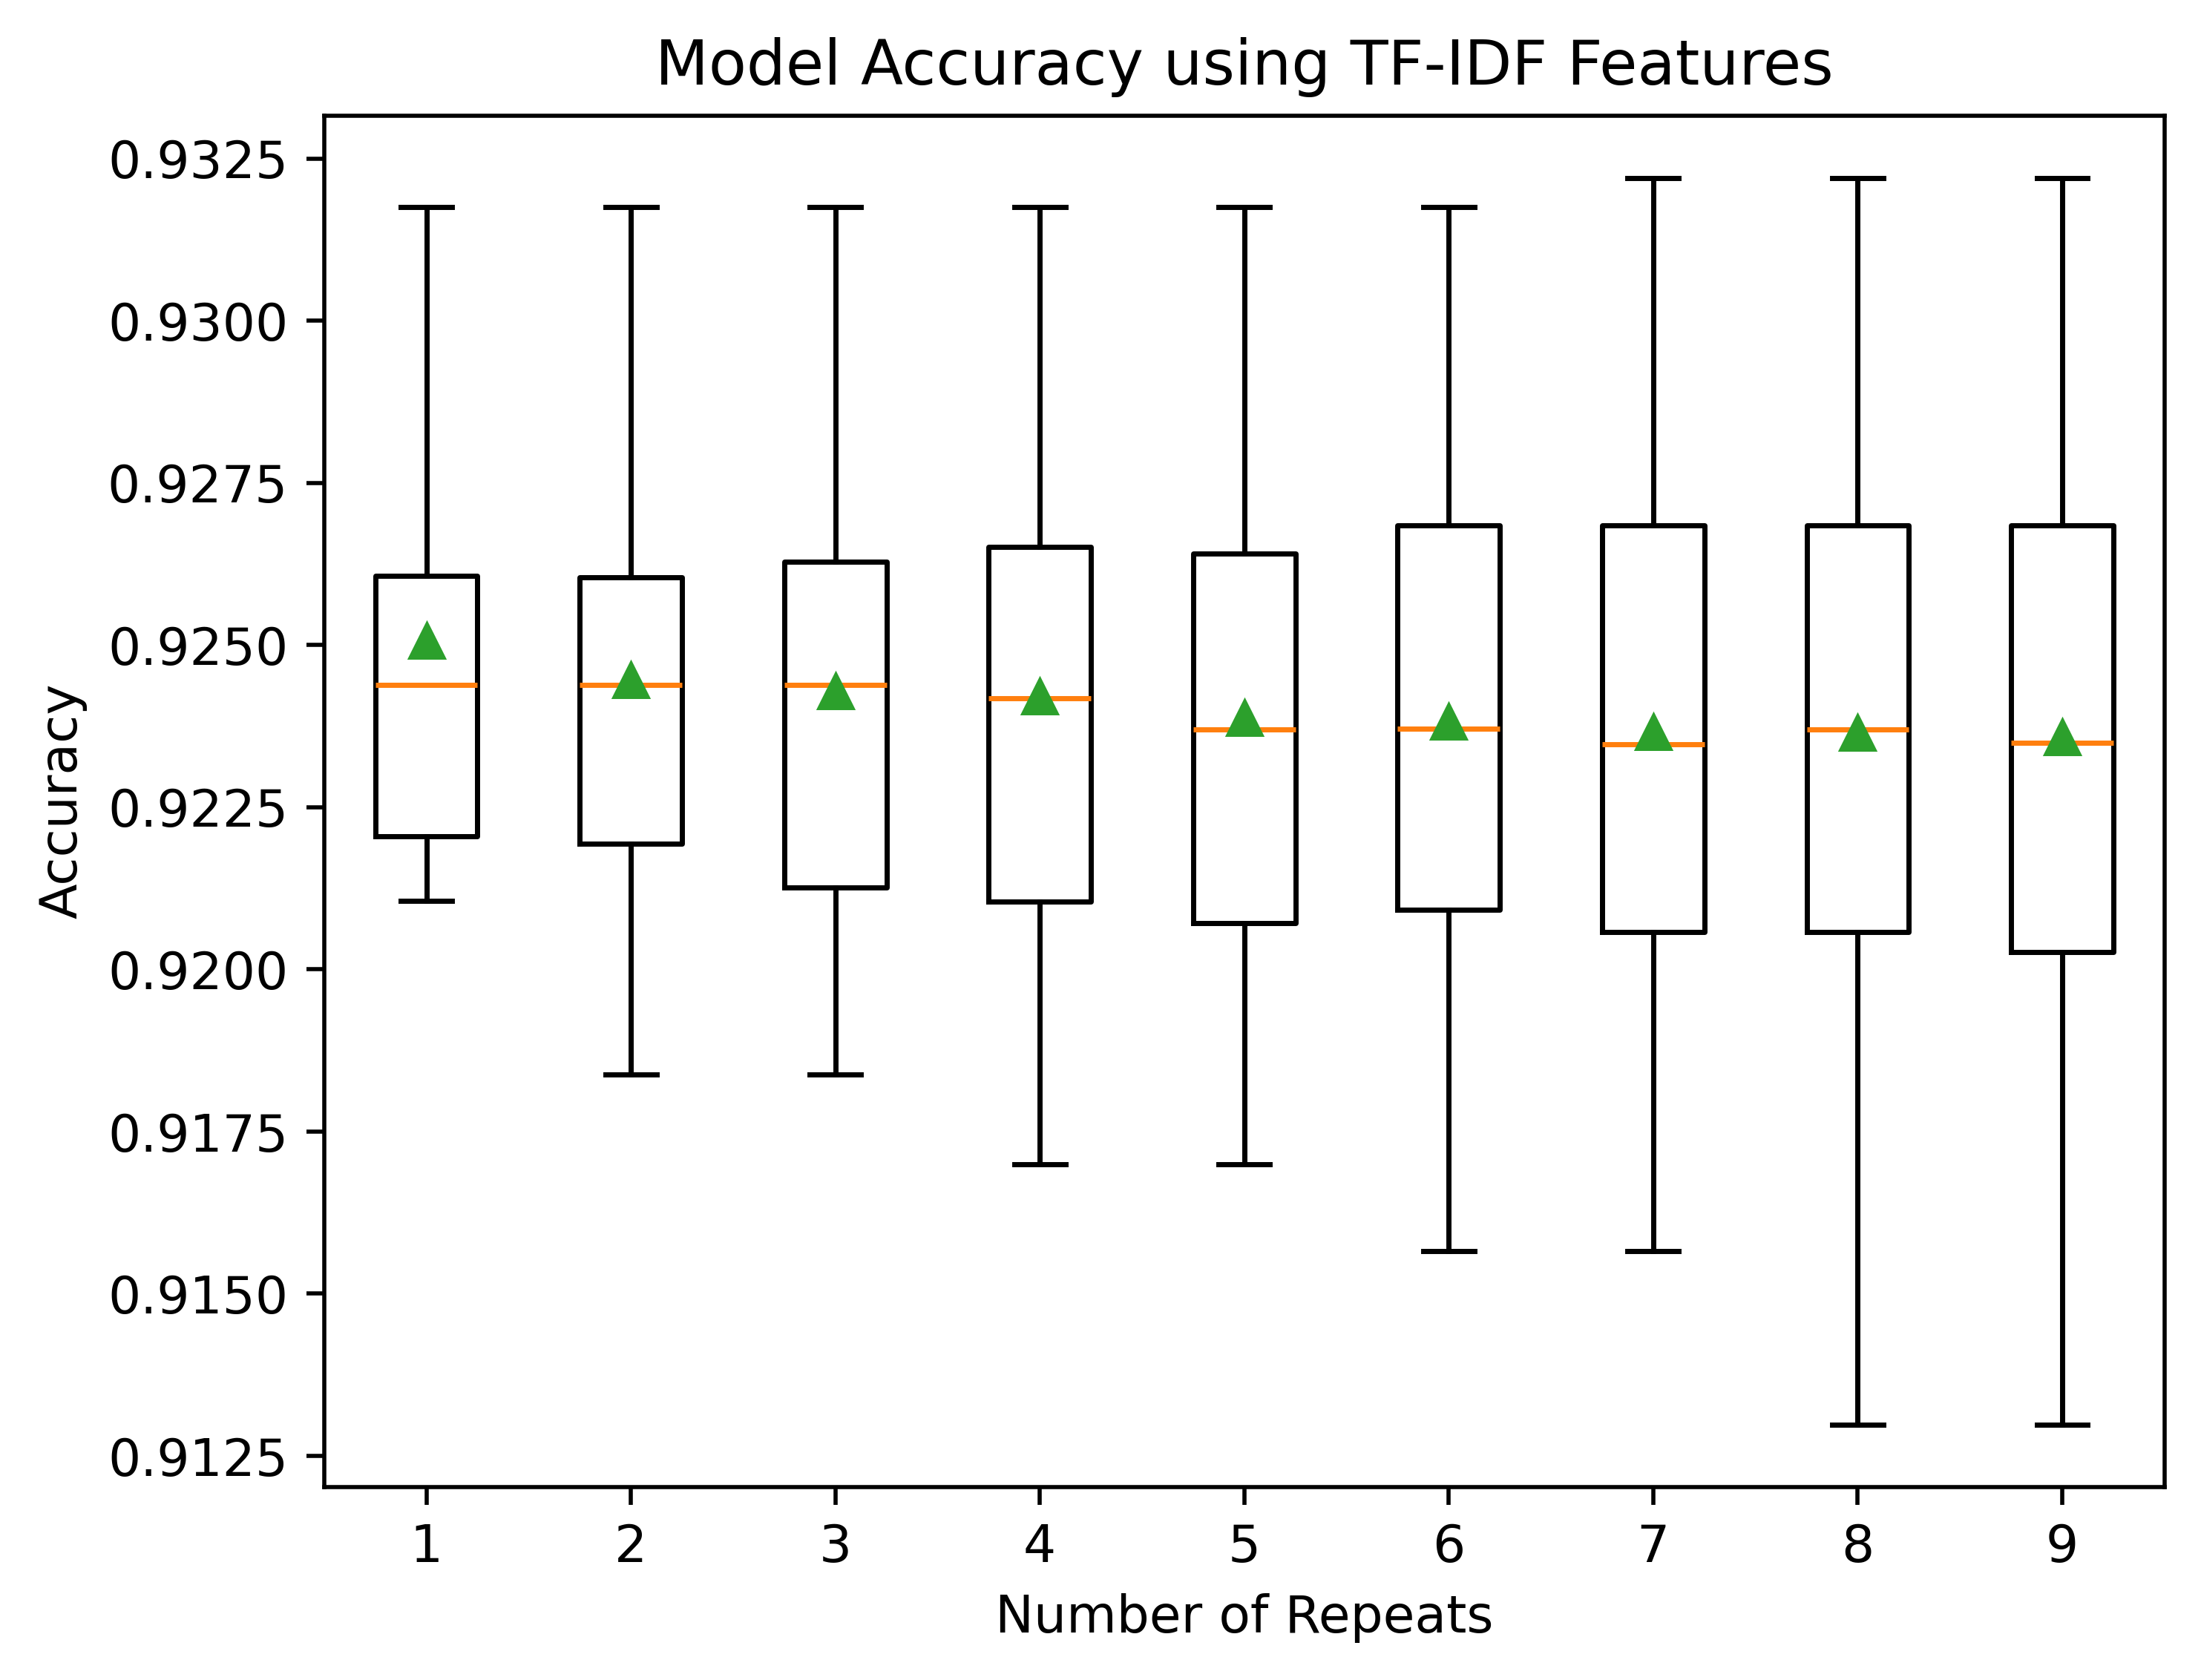

In [16]:
repeats = range(1,10)

results = list()
for r in repeats:
	# evaluate using a given number of repeats
	scores = evaluate_model(X_tfidf_combined, y, r)
	# summarize
	print('>%d mean=%.8f se=%.3f' % (r, np.mean(scores), sem(scores)))
	# store
	results.append(scores)

# Plot the results of the evaluations
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.title('Model Accuracy using TF-IDF Features')
plt.ylabel('Accuracy')
plt.xlabel('Number of Repeats')
plt.show()

# Save results
model = "xgb_tfidf"
dataset = "145"
results = pd.DataFrame(results)
results.to_csv(f'k-fold_results/{dataset}/{model}.csv', index=False)

>1 mean=0.92478912 se=0.002
>2 mean=0.92476706 se=0.001
>3 mean=0.92435792 se=0.001
>4 mean=0.92394155 se=0.001
>5 mean=0.92395055 se=0.001
>6 mean=0.92397875 se=0.001
>7 mean=0.92398622 se=0.000
>8 mean=0.92414791 se=0.000
>9 mean=0.92407050 se=0.000


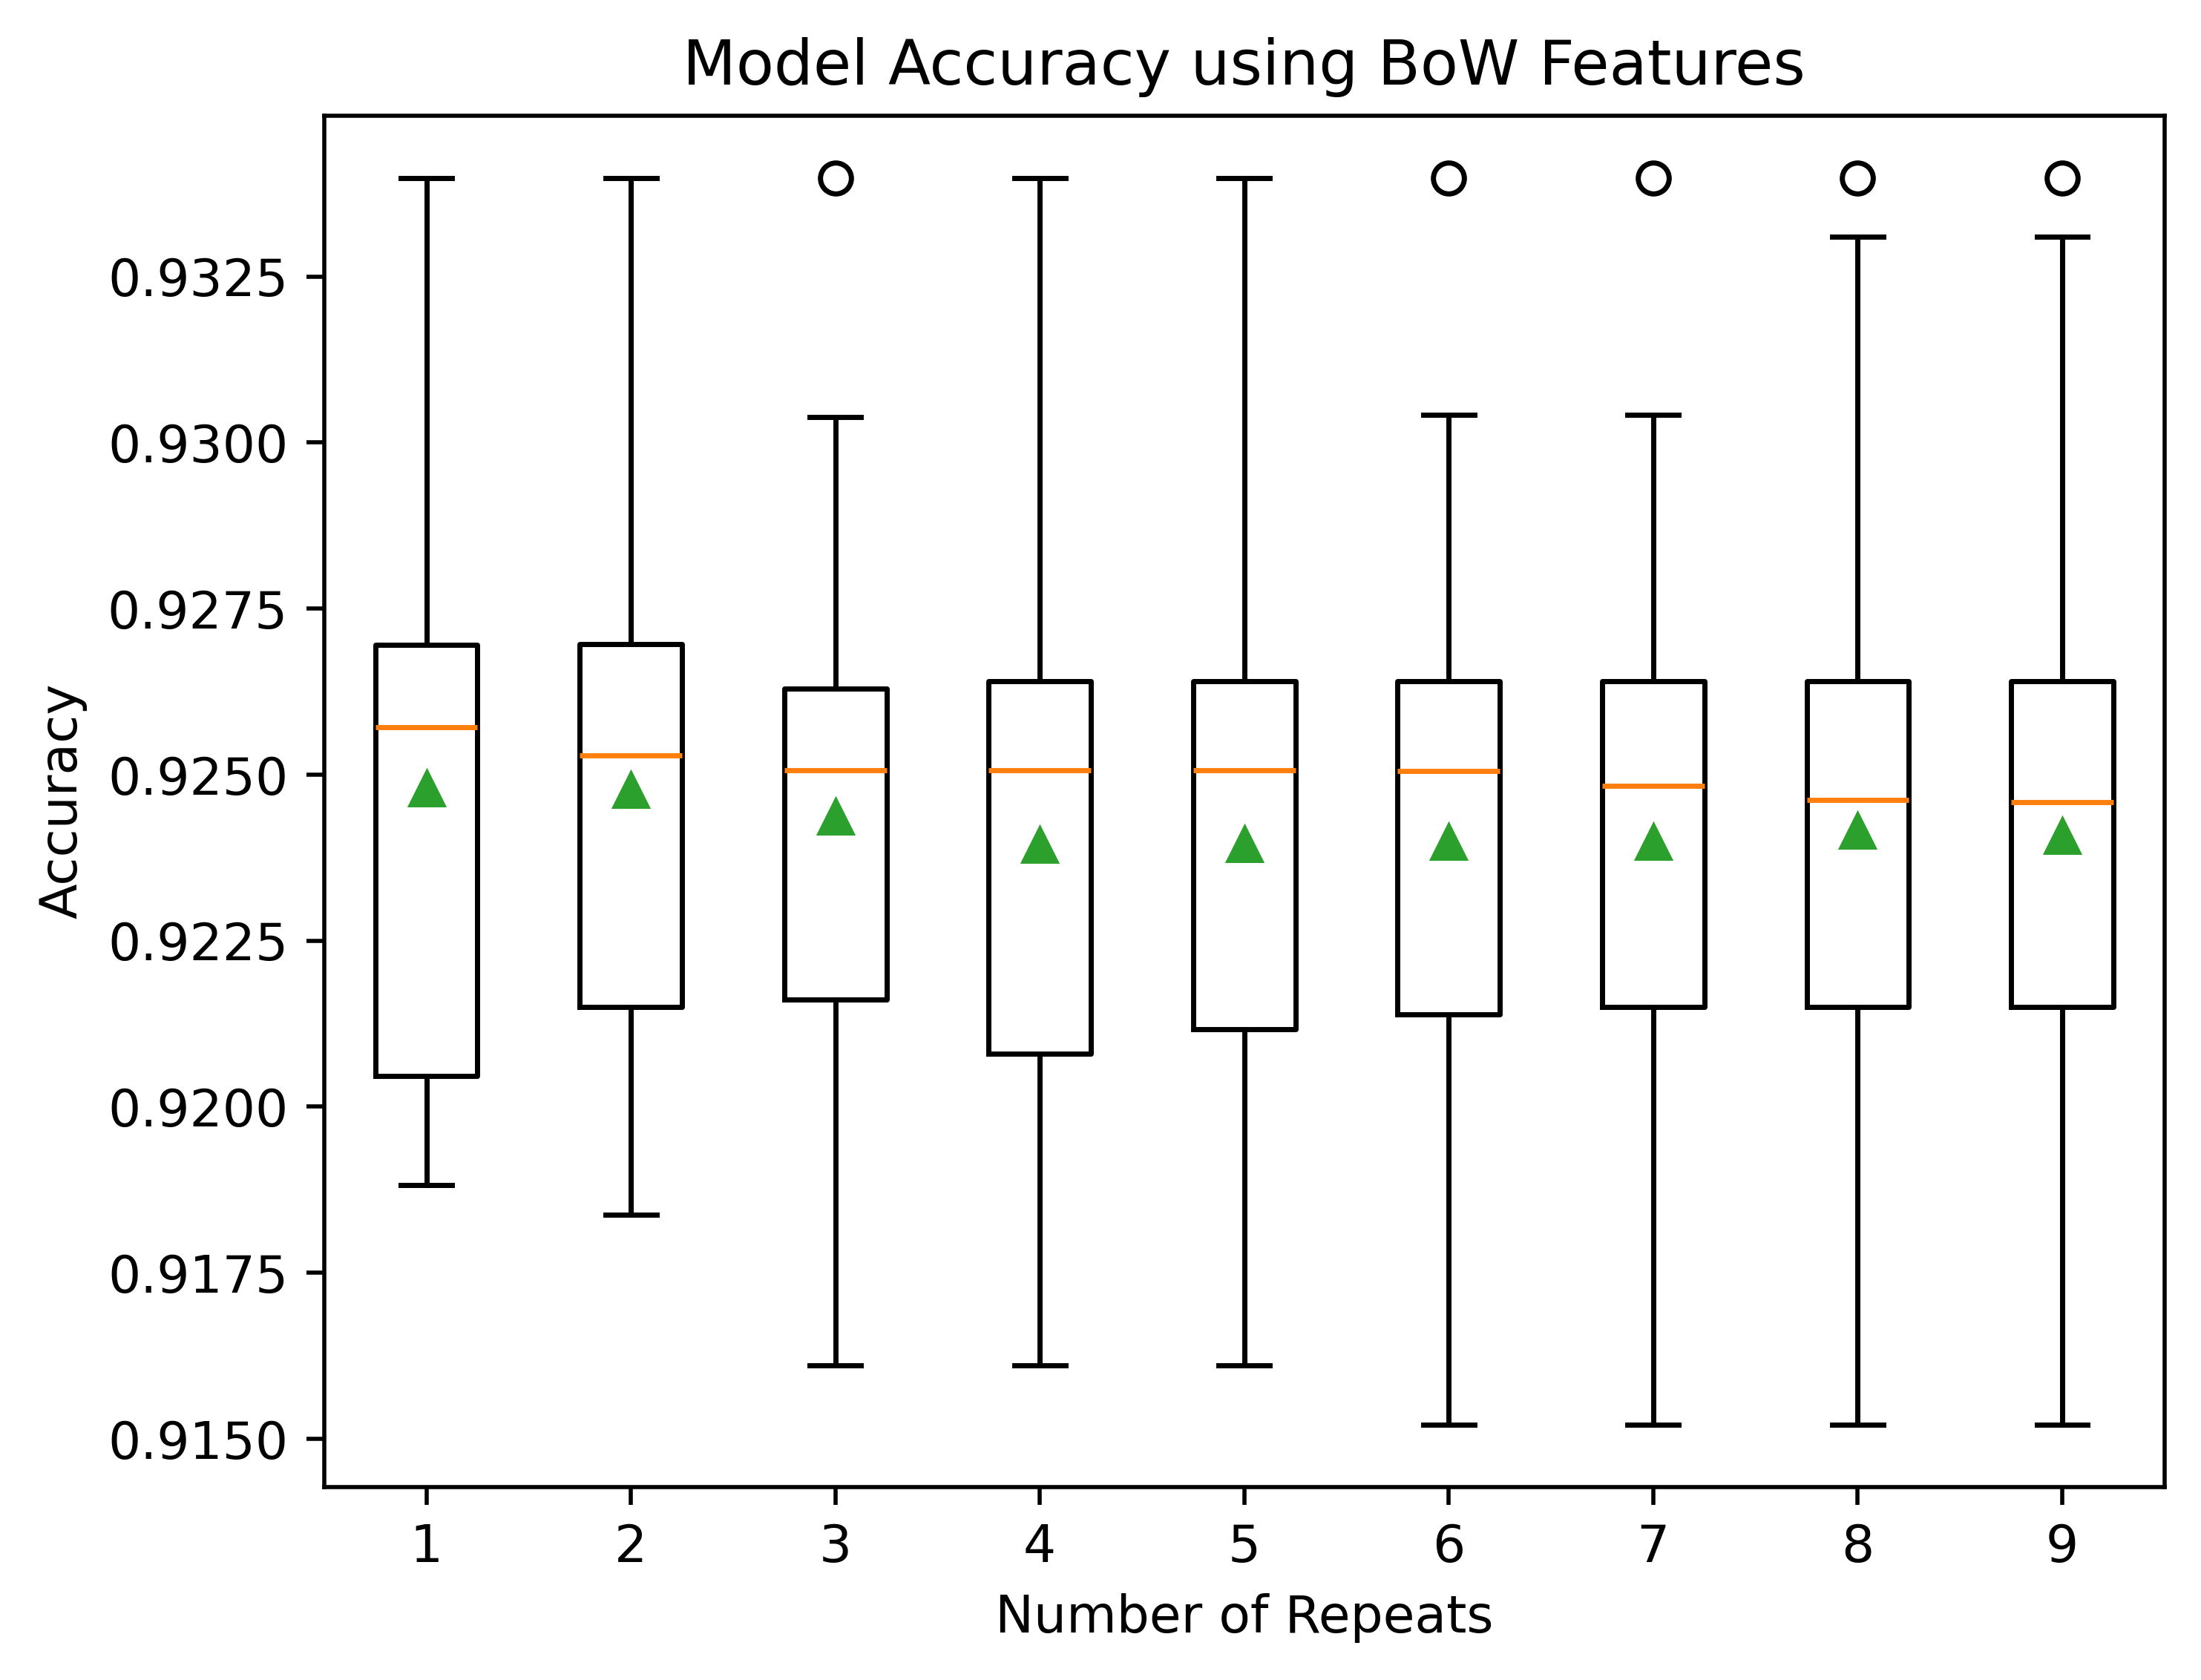

In [17]:
results = list()

for r in repeats:
	# evaluate using a given number of repeats
	scores = evaluate_model(X_bow_combined, y, r)
	# summarize
	print('>%d mean=%.8f se=%.3f' % (r, np.mean(scores), sem(scores)))
	# store
	results.append(scores)

# Plot the results of the evaluations
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.title('Model Accuracy using BoW Features')
plt.ylabel('Accuracy')
plt.xlabel('Number of Repeats')
plt.show()

# Save results
model = "xgb_bow"
dataset = "145"
results = pd.DataFrame(results)
results.to_csv(f'k-fold_results/{dataset}/{model}.csv', index=False)

## **Hyperparameter Tuning**

In [5]:
def train_evaluate_model(X_train, y_train, optimization):
    model = XGBClassifier(n_estimators=3000, random_state=40)
    
    param_grid = {
            'learning_rate': [.2, .3, .4],
            'max_depth': [3, 5, 10],
            'gamma': [0.1,.2,.3],
            'reg_alpha': [.001, .01, .1]
        }
    
    # Define parameter grid for GridSearchCV
    if optimization == 'gridsearch':
        optimizer = GridSearchCV(model, param_grid, scoring='accuracy', cv=10, verbose=1, n_jobs=-1)
    
    # Define parameter distributions for RandomizedSearchCV
    elif optimization == 'randomsearch':
        optimizer = RandomizedSearchCV(model, param_grid, n_iter=300, scoring='accuracy', cv=10, verbose=1, n_jobs=-1)
    
    # Fit the optimizer/model on the training data
    optimizer.fit(X_train, y_train)
    
    return optimizer

In [6]:
def calculate_accuracy(model, X_test, y_test):
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    return accuracy

In [ ]:
# Feature sets and their labels
feature_sets = {
    # 'TF-IDF': (X_train_tfidf, X_test_tfidf)
    'BoW': (X_train_bow, X_test_bow)
}

# Optimization methods to be used
optimizations = ['gridsearch', 'randomsearch']

# Placeholder for results
results = []

# Iterate over each combination of feature set and optimization method
for feature_label, (X_train, X_test) in feature_sets.items():
    for optimization in optimizations:
        print(f"Running {feature_label} with {optimization}")
        model = train_evaluate_model(X_train, y_train, optimization=optimization)
        
        # Calculate additional metrics
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions, average='weighted')
        
        # Store the results including additional metrics
        results.append({
            'Feature Set': feature_label,
            'Optimization': optimization,
            'Model': model,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
        })

In [ ]:
# Convert results to DataFrame for easier handling
results_df = pd.DataFrame(results)

print(results_df[['Feature Set', 'Optimization', 'Accuracy', 'Precision', 'Recall', 'F1 Score']])

### Best Model

In [29]:
best_model = results_df.iloc[1]['Model']

print('Best Parameters:', best_model.best_params_,end='\n\n')

print('Best Score:', best_model.best_score_)

Best Parameters: {'reg_alpha': 0.01, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.3}

Best Score: 0.9440606532687598


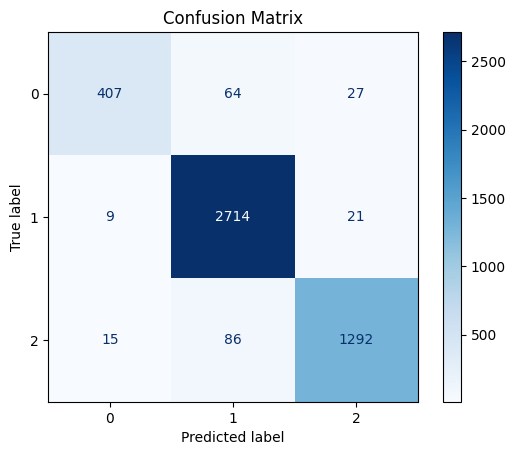

In [31]:
# Predicting the target values for the test set to evaluate the model's performance on unseen data.
predictions = best_model.predict(X_test_bow)

# Generating a confusion matrix from the predictions to understand the model's prediction behavior.
# This matrix shows the discrepancies between actual and predicted classifications.
cm = confusion_matrix(y_test, predictions)

# Displaying the confusion matrix using a visualization to make the discrepancies more apparent.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()